<a href="https://colab.research.google.com/github/seojeongyun/naver_movie_review_sentiment_analysis/blob/main/naver_movie_review_sentimentation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
cd "/content/drive/My Drive/ratings_train.txt"

[Errno 20] Not a directory: '/content/drive/My Drive/ratings_train.txt'
/content


In [63]:
!git clone https://github.com/seojeongyun/naver_movie_review_sentiment_analysis

fatal: destination path 'naver_movie_review_sentiment_analysis' already exists and is not an empty directory.


In [64]:
import urllib

if __name__ == '__main__':
    # Data download from url
    urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                               filename="/content/drive/My Drive/ratings_train.txt")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                               filename="/content/drive/My Drive/ratings_test.txt")

In [65]:
pip install konlpy

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import re
import numpy as np
import urllib

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class process:
    def __init__(self):
        # data save using pandas
        self.train_data = pd.read_table('/content/drive/My Drive/ratings_train.txt')
        self.test_data = pd.read_table('/content/drive/My Drive/ratings_test.txt')
        self.stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
        #
        self.Okt = Okt() # Open Korean Text
        self.tokenizer = Tokenizer()
        #
        self.threshold = 3
        self.rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
        self.total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
        self.rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
        self.vocab_size = 0


    def dataset_len(self, type: str):  # Check the number of datasets
        if type == 'train':
            print('The number of train reviews : ', len(self.train_data))
        else:
            print('The number of test reviews : ', len(self.test_data))


    def preprocess(self, type: str):
        if type == 'train':
            # Remove duplications column of document
            self.train_data.drop_duplicates(subset=['document'], inplace=True)

            # Remove the samples with null value
            train_data = self.train_data.dropna(how='any')

            # Remove special characters with regular expression
            train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

            # Change the white space value to Null value and then remove
            train_data['document'] = train_data['document'].str.replace('^ +', "")  # change the white space to empty value
            train_data['document'].replace('', np.nan, inplace=True)
            print(train_data.isnull().sum())
            train_data = train_data.dropna(how='any')

            y_train = np.array(train_data['label']) # get labels
            return train_data, y_train

        else:
            # Apply same preprocess to test dataset
            self.test_data.drop_duplicates(subset=['document'], inplace=True)

            # Remove the samples with null value
            test_data = self.train_data.dropna(how='any')

            # remove duplicate value for column of ducument
            test_data['document'] = self.test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")  # Apply regular expression
            test_data[:5]

            test_data['document'] = self.test_data['document'].str.replace('^ +', "")  # change the white space to empty value
            test_data['document'].replace('', np.nan, inplace=True)  # change epmty space to null value
            test_data = test_data.dropna(how='any')  # remove the null value
            y_test = np.array(test_data['label'])
            return test_data, y_test


    def check_duplication(self):  # Check duplications column of document and label
        self.train_data['document'].nunique(), self.train_data['label'].nunique()
        self.test_data['document'].nunique(), self.test_data['label'].nunique()


    def remove_stopword(self, type: str, data):
        if type == 'train':
            X_train = []
            for sentence in tqdm(data['document']):
                tokenized_sentence = (self.Okt.morphs(sentence, stem=True))  # 토큰화
                stopwords_removed_sentence = [word for word in tokenized_sentence if not word in self.stopwords]  # 불용어 제거
                X_train.append(stopwords_removed_sentence)
            return X_train

        else:
            X_test = []
            for sentence in tqdm(data['document']):
                tokenized_sentence = self.Okt.morphs(sentence, stem=True)  # 토큰화
                stopwords_removed_sentence = [word for word in tokenized_sentence if not word in self.stopwords]  # 불용어 제거
                X_test.append(stopwords_removed_sentence)
            return X_test


    def integer_encoding(self, data):
        return self.tokenizer.fit_on_texts(data)


    def set_vocab_size(self, data):
        train_token = self.tokenizer.fit_on_texts(data) #정수 인코딩

        self.total_cnt = len(self.tokenizer.word_index) # 단어의 수

        # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
        for key, value in self.tokenizer.word_counts.items(): # key : word , value : value of freq
            self.total_freq = self.total_freq + value

            # 단어의 등장 빈도수가 threshold보다 작으면
            if(value < self.threshold):
                self.rare_cnt = self.rare_cnt + 1
                self.rare_freq = self.rare_freq + value

        print('단어 집합(vocabulary)의 크기 :',self.total_cnt)
        print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(self.threshold - 1, self.rare_cnt))
        print("단어 집합에서 희귀 단어의 비율:", (self.rare_cnt / self.total_cnt)*100)
        print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (self.rare_freq / self.total_freq)*100)

        ### 등장 빈도수 보다 작으면 제거
        self.vocab_size = self.total_cnt - self.rare_cnt + 1
        print('단어 집합의 크기 :',self.vocab_size)

        return self.vocab_size

        #
    def text2int(self, data, type):
        tokenizer = Tokenizer(self.vocab_size)
        tokenizer.fit_on_texts(data)
        if type=='train':
            X_train = tokenizer.texts_to_sequences(data)
            return X_train
        else:
            X_test = tokenizer.texts_to_sequences(data)
            return X_test

In [67]:
import torch.nn as nn
import torch.optim as optim
import torch


class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim, dropout):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
    self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
    self.linear = nn.Linear(hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
    self.sigmoid = torch.sigmoid

  def forward(self, x):
    embed = self.dropout(self.embedding(x))
    output, _ = self.rnn(embed)
    output = self.linear(output[:, -1, :])
    output = self.sigmoid(output)
    return output

  def predict(self, output):
    prob = output
    prob[prob > 0.5] = 1
    prob[prob <= 0.5] = 0
    return prob

  def _init_state(self, batch_size=1):
    weight = next(self.parameters()).data
    return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [68]:
from torch.utils.data import Dataset

class dataloader(Dataset):
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [69]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


def accuracy(pred, target):
    return torch.sum(pred == target).item()


def train(model, train_loader):
  model.train()

  epoch_loss, epoch_acc = 0, 0
  for i, batch_data in enumerate(train_loader):
    optimizer.zero_grad()
    x, y = batch_data[0], batch_data[1]
    y_hat = model(x).squeeze(1)

    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    pred = model.predict(y_hat)
    epoch_acc += accuracy(pred, y)
    epoch_loss += loss.item()

  return epoch_loss / (len(train_loader)*5), epoch_acc / (len(train_loader)*5)

In [70]:
### 클래스 선언
process = process()

In [71]:
### 데이터 중복, 결측치 제거
X_train, Y_train = process.preprocess('train')
X_test, Y_test = process.preprocess('test')

<ipython-input-66-3a7a11df523a>:48: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
<ipython-input-66-3a7a11df523a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
<ipython-input-66-3a7a11df523a>:51: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")  # change the white space to empty value
<ipython-input-66-3a7a11df523a>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

id            0
document    789
label         0
dtype: int64


<ipython-input-66-3a7a11df523a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'] = self.test_data['document'].str.replace('^ +', "")  # change the white space to empty value
<ipython-input-66-3a7a11df523a>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'].replace('', np.nan, inplace=True)  # change epmty space to null value


In [72]:
## 불용어 제거
X_train_removed = process.remove_stopword('train', X_train[:10000])
# X_test_removed = process.remove_stopword('test', X_test[:10000])

100%|██████████| 10000/10000 [01:03<00:00, 157.19it/s]


In [73]:
print(X_train_removed[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [74]:
### 등장 빈도 수 낮은 단어 제외
vocab_size = process.set_vocab_size(X_train_removed)

단어 집합(vocabulary)의 크기 : 12446
등장 빈도가 2번 이하인 희귀 단어의 수: 8202
단어 집합에서 희귀 단어의 비율: 65.90069098505545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.122327672779582
단어 집합의 크기 : 4245


In [75]:
print(process.tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '다': 8, '너무': 9, '정말': 10, '재밌다': 11, '만': 12, '적': 13, '같다': 14, '되다': 15, '진짜': 16, '아니다': 17, '로': 18, '점': 19, '않다': 20, '에서': 21, '나오다': 22, '연기': 23, '만들다': 24, '평점': 25, '것': 26, '최고': 27, '안': 28, '인': 29, '나': 30, '그': 31, '내': 32, '못': 33, '스토리': 34, '사람': 35, '드라마': 36, '왜': 37, '보고': 38, '게': 39, '고': 40, '감동': 41, '생각': 42, '이렇다': 43, 'ㅋㅋ': 44, '감독': 45, '아깝다': 46, '때': 47, '말': 48, '그냥': 49, '시간': 50, '배우': 51, '더': 52, '거': 53, '아': 54, '재미없다': 55, '요': 56, '내용': 57, '재미': 58, '지루하다': 59, '재미있다': 60, '하고': 61, '중': 62, '자다': 63, '주다': 64, '까지': 65, '네': 66, '뭐': 67, '모르다': 68, '가다': 69, '들다': 70, '작품': 71, '쓰레기': 72, '알다': 73, '수': 74, '하나': 75, '지': 76, '싶다': 77, '사랑': 78, '그렇다': 79, '이건': 80, '볼': 81, '정도': 82, '이렇게': 83, '액션': 84, '다시': 85, 'ㅋ': 86, '마지막': 87, '저': 88, '개': 89, '차다': 90, '기': 91, '연출': 92, '주인공': 93, '걸': 94, '돈': 95, '느낌': 96, 'ㅠㅠ': 97, '완전': 98, '역시': 99, 'ㅡㅡ': 100, '많다': 101, '최악': 102,

In [76]:
### text2sequence
train_token = process.text2int(data=X_train_removed, type='train')
# test_token = process.text2int(data=X_test_removed, type='test')

In [77]:
print(train_token[:3])

[[54, 681, 16, 239, 782], [682, 349, 38, 641, 1, 163, 1842, 23, 899, 728, 20], [359, 1536, 2034, 2, 228, 8]]


In [78]:
### remove empty sample
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
x_train = np.delete(train_token, drop_train, axis=0)
y_train = np.delete(Y_train, drop_train, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [79]:
### padding
max_len = 30
below_threshold_len(max_len, x_train)
X_train = pad_sequences(x_train, maxlen=max_len)
# X_test = pad_sequences(test_token, maxlen=max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.24000000000001


In [80]:
embedding_dim = 100
hidden_dim = 128
dropout = 0.3
batch_size = 5

model = LSTM(input_dim=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [81]:
from torch.utils.data.dataloader import DataLoader

dataloader = dataloader(X_train, Y_train)
train_loader = DataLoader(dataloader,
                          batch_size=5,
                          shuffle=True)

In [82]:
train_loss = []
train_acc = []

for _epoch in range(5): # 5 epoch
  print("start {} epoch".format(_epoch))
  loss, acc = train(model, train_loader)
  train_loss.append(loss)
  train_acc.append(acc)

start 0 epoch
start 1 epoch
start 2 epoch
start 3 epoch
start 4 epoch


In [83]:
import matplotlib.pyplot as plt

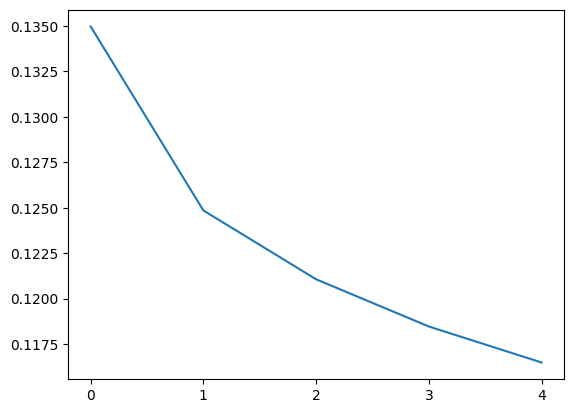

In [84]:
fig = plt.figure()
plt.plot(list(range(5)), train_loss)
plt.xticks(list(range(5)), list(range(5)))
plt.show()

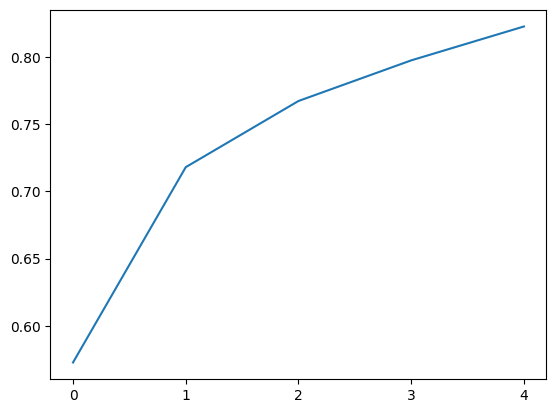

In [85]:
fig = plt.figure()
plt.plot(list(range(5)), train_acc)
plt.xticks(list(range(5)), list(range(5)))
plt.show()

In [86]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

Okt = Okt()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [91]:
new_sentence = '이게 영화지 ㅋㅋ'
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = Okt.morphs(new_sentence, stem=True) # 토큰화
new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

encoded = process.tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
pad_new = torch.from_numpy(pad_new)

model.eval()
score = model(pad_new)
score = score.detach()[0].item()


if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

93.45% 확률로 긍정 리뷰입니다.



In [93]:
new_sentence = '이게 영화냐 ㅋㅋ'
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = Okt.morphs(new_sentence, stem=True) # 토큰화
new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

encoded = process.tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
pad_new = torch.from_numpy(pad_new)

model.eval()
score = model(pad_new)
score = score.detach()[0].item()


if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

99.13% 확률로 부정 리뷰입니다.

